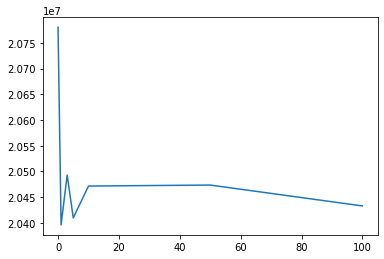

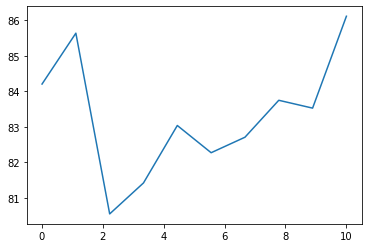

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def centriranje_izlaza(izlaz):
    srednja_vrednost = np.mean(izlaz)
    #devijacija = np.std(izlaz)
    centriran_izlaz = np.zeros((len(izlaz),1))
    for i in range(len(izlaz)):
        centriran_izlaz[i] = izlaz[i] - srednja_vrednost
    #centriran_izlaz = centriran_izlaz/devijacija
    return centriran_izlaz

def lazni_prediktori(pravi_prediktori):
    vrsta,kolona = pravi_prediktori.shape
    kvadrati = np.multiply(pravi_prediktori,pravi_prediktori)
    povratna_matrica = np.c_[pravi_prediktori,kvadrati]
    for i in range(kolona):
        for j in range(kolona):
            if(j > i):
                pomocni_vektor = np.multiply(pravi_prediktori[:,i],pravi_prediktori[:,j])
                povratna_matrica = np.c_[povratna_matrica,pomocni_vektor]
    return povratna_matrica

def standardizacija(matrica_prediktora):
    vrsta,kolona = matrica_prediktora.shape
    matrica = np.zeros((vrsta,kolona))
    ocekivanja = matrica_prediktora.mean(0)
    devijacija = matrica_prediktora.std(0)
    for i in range(kolona):
        matrica[:,i] = (matrica_prediktora[:,i] - ocekivanja[i])/devijacija[i]
    return matrica

def mesanje_trening_test(ulaz,izlaz):
    slucajni_niz = np.random.permutation(len(izlaz))
    X_trening = ulaz[slucajni_niz[0:int(np.floor(0.85*(len(slucajni_niz)-1)))],:]
    Y_trening = izlaz[slucajni_niz[0:int(np.floor(0.85*(len(slucajni_niz)-1)))]]
    X_test = ulaz[slucajni_niz[int(np.floor(0.85*(len(slucajni_niz)-1))):len(slucajni_niz)],:]
    Y_test = izlaz[slucajni_niz[int(np.floor(0.85*(len(slucajni_niz)-1))):len(slucajni_niz)]]
    return X_trening,Y_trening,X_test,Y_test



def metrika_racun(X_validacija,Y_validacija,theta_optimalno):
    vrste,kolone = X_validacija.shape
    suma_konacno = 0
    for i in range(vrste):
        suma = 0
        for j in range(kolone):
            suma = suma + (X_validacija[i,j]*theta_optimalno[j])
        suma_konacno = suma_konacno + np.square(suma - Y_validacija[i])
    return suma_konacno


def model(X):
    global optimalno_theta,theta0
    optimalno_theta = np.matrix([optimalno_theta]).T
    X_lazno_novo = lazni_prediktori(X)
    X_novo = standardizacija(X_lazno_novo)
    vrsta,kolona = X_novo.shape
    y_kapa = np.dot(X_novo,optimalno_theta)+theta0
    return y_kapa

                               
podaci = pd.read_csv('/content/drive/MyDrive/data.csv', header=None)
#podaci = podaci.values

vrste,kolone = podaci.shape
prediktori = np.zeros((vrste,kolone-1))
Y = np.zeros((vrste,1))
for i in range(vrste):
    prediktori[i] = np.array(podaci.iloc[i][0:kolone-1])
    Y[i] = podaci.iloc[i][kolone-1]
    
X_trening,Y_trening,X_test,Y_test = mesanje_trening_test(prediktori,Y)
theta0 = Y_trening.mean()
theta0=np.matrix([theta0])

X_lazno = lazni_prediktori(X_trening)
X_standardizovano = standardizacija(X_lazno)
vrsta_tr,kolona_tr = X_standardizovano.shape
Y_centralizovano = centriranje_izlaza(Y_trening)

korak = int(np.floor(vrsta_tr/5))
hiperparametar = np.array([0,1,3,5,10,50,100])

fold_x = [X_standardizovano[0:korak,:],X_standardizovano[korak:2*korak,:],\
          X_standardizovano[2*korak:3*korak,:],X_standardizovano[3*korak:4*korak,:],\
              X_standardizovano[4*korak:,:]]
fold_y = [Y_centralizovano[0:korak],Y_centralizovano[korak:2*korak],\
          Y_centralizovano[2*korak:3*korak],Y_centralizovano[3*korak:4*korak],\
              Y_centralizovano[4*korak:]]
    
niz_lambda_mean = np.zeros((len(hiperparametar),1))
niz_lambda_std = np.zeros((len(hiperparametar),1))

for i in range(len(hiperparametar)):
    metrika = np.zeros((5,1))
    for j in range(5):
        X_validacija = np.matrix(fold_x[j])
        Y_validacija = np.matrix(fold_y[j])
        lista_x_obucavanje = fold_x[:j] + fold_x[j+1:]
        lista_y_obucavanje = fold_y[:j] + fold_y[j+1:]
        X_obucavanje = np.matrix(lista_x_obucavanje[0])
        Y_obucavanje = np.matrix(lista_y_obucavanje[0])
        for k in range(4):
            if(k != 0):
                X_obucavanje = np.r_[X_obucavanje,np.matrix(lista_x_obucavanje[k])]
                Y_obucavanje = np.r_[Y_obucavanje,np.matrix(lista_y_obucavanje[k])]

        theta_pocetno = 10*np.random.randn(20,1)
        J = lambda theta: np.sum(np.square(np.dot(X_obucavanje,theta)-Y_obucavanje)) + (hiperparametar[i]*np.sum(np.absolute(theta)))
        theta_opt = minimize(J,theta_pocetno,method='Nelder-Mead')
        metrika[j] = np.sum(np.square(np.dot(X_validacija,theta_opt.x)-Y_validacija))
    niz_lambda_mean[i] = np.mean(metrika)
    niz_lambda_std[i] = np.std(metrika)
    

plt.figure(1)
plt.plot(hiperparametar,niz_lambda_mean) 


#%%
#najmanje = np.argmin(niz_lambda_mean)
#optimalno_lambda = hiperparametar[najmanje]
optimalno_lambda = 100
#%%
Optimalno_lambda = np.linspace(0.01,10,10)
rmse = np.zeros([len(Optimalno_lambda),1])
for i in range(0,len(Optimalno_lambda)):
    optimalno_labda = Optimalno_lambda[i]
    theta_pocetno = 10*np.random.randn(20,1)
    J = lambda theta: np.sum(np.square(np.dot(X_standardizovano,theta)-Y_centralizovano)) + (optimalno_lambda*np.sum(np.absolute(theta)))
    optimalno_theta_objekat = minimize(J,theta_pocetno,method='Nelder-Mead')
    optimalno_theta = optimalno_theta_objekat.x

    y_pred = model(X_test)

    rmse[i] = np.sqrt(np.mean(np.square(y_pred-Y_test)))

#%%

plt.figure(2)
plt.plot(Optimalno_lambda,rmse)
#plt.plot(Y_test)
#plt.plot(y_pred)

#print(rmse)

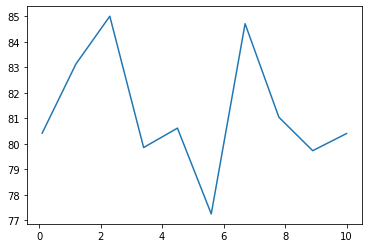

In [55]:
theta

81.11307701221175


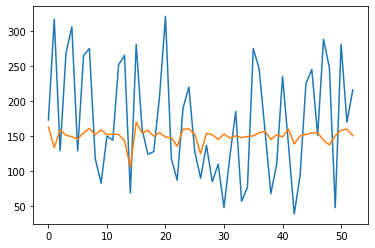

In [73]:
hiperparametar = 100
J = lambda theta: np.sum(np.square(np.dot(X_obucavanje,theta)-Y_obucavanje)) + (hiperparametar*np.sum(np.absolute(theta)))
optimalno_theta_objekat = minimize(J,theta_pocetno,method='Nelder-Mead')
optimalno_theta = optimalno_theta_objekat.x

y_pred = model(X_test)

rmse= np.sqrt(np.mean(np.square(y_pred-Y_test)))

#%%

plt.figure(2)
plt.plot(Y_test)
plt.plot(y_pred)

print(rmse)

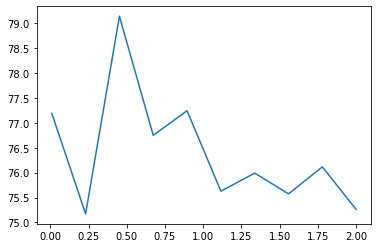

In [65]:

Optimalno_lambda = np.linspace(0.01,2,10)
rmse = np.zeros([len(Optimalno_lambda),1])
for i in range(0,len(Optimalno_lambda)):
    optimalno_labda = Optimalno_lambda[i]
    theta_pocetno = 10*np.random.randn(20,1)
    J = lambda theta: np.sum(np.square(np.dot(X_standardizovano,theta)-Y_centralizovano)) + (optimalno_lambda*np.sum(np.absolute(theta)))
    optimalno_theta_objekat = minimize(J,theta_pocetno,method='Nelder-Mead')
    optimalno_theta = optimalno_theta_objekat.x

    y_pred = model(X_test)

    rmse[i] = (np.dot((y_pred-Y_test),(y_pred-Y_test).T)/y_pred.shape[1])**0.5
   

#%%

plt.figure(2)
plt.plot(Optimalno_lambda,rmse)



In [4]:
4+9+16
np.sqrt(np.mean(np.square([2,3,4])))

3.1091263510296048

In [13]:
(np.dot([2,3,4],[2,3,4])/3)**0.5

3.1091263510296048